logo_dantion.png

This project is about traffic accident and street crime audio-based detection. We created this project to complete our study in **Bangkit 2022 led by GoTo, Traveloka and Tokopedia**

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import models

## Import dataset from Google Drive

In [ ]:
#from google.colab import files

In [4]:
data_dir = '/content/gdrive/MyDrive/Audio Dataset Dantion/FINAL DATASET'

## Import datset from Local Drive

In [5]:
data_dir = 'ML Path/DATASET FINAL'

In [6]:
event = os.listdir(data_dir)
event

['Crash', 'Horn']

## Directory Structure

In [7]:
def get_numfiles(dir):
    """Get number of files in a directory"""
    count = 0
    for _, _, files in os.walk(dir):
        count += len(files)
    return count

In [8]:
def get_files(dir):
    '''Get all file path and convert to EagerTensor'''
    filedir = str(dir) + ("/*/*.wav") #Get .wav files directory
    files = tf.io.gfile.glob(filedir) #Returns a list of files that match the given pattern
    files = tf.random.shuffle(files) #Randomly shuffles a tensor along its first dimension
    return files

In [9]:
"Total dataset : " + str(get_numfiles(data_dir))

'Total dataset : 2317'

In [10]:
filenames = get_files(data_dir)

In [11]:
def split_data(data,ratio1,ratio2,ratio3):
    '''Split dataset into desired ratio'''
    if ratio1+ratio2+ratio3 == 100 :
        ratio1 = round(len(data)*ratio1/100)
        ratio2 = round(len(data)*ratio2/100)
        ratio3 = round(len(data)*ratio3/100)
        train_files = data[:ratio1]
        val_files = data[ratio1: ratio1 + ratio2]
        test_files = data[-ratio3:]
    else :
        raise ValueError('Exceeding the limit ratio, the total ratio must be 100% but you got ' + str(ratio1+ratio2+ratio3) + 
    '%')
    return train_files,val_files,test_files

In [12]:
train, val, test = split_data(filenames,80,10,10)

## Read Audio and Labels

In [13]:
def decode_audio(audio_dir):
  '''Decode .wav Audio into mono Audio Tensor'''
  audiofile = tf.io.read_file(audio_dir)
  audio, _ = tf.audio.decode_wav(audiofile,desired_channels=1) 
  return tf.squeeze(audio, axis=-1)

In [14]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  waveform = decode_audio(file_path)
  return waveform, label

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

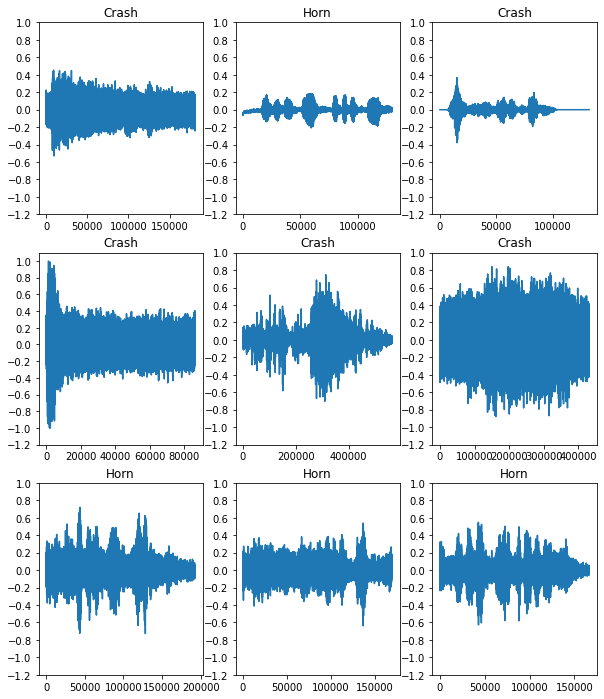

In [17]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [18]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [19]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
#display.display(display.Audio(waveform, rate=16000))

Label: Crash
Waveform shape: (180990,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

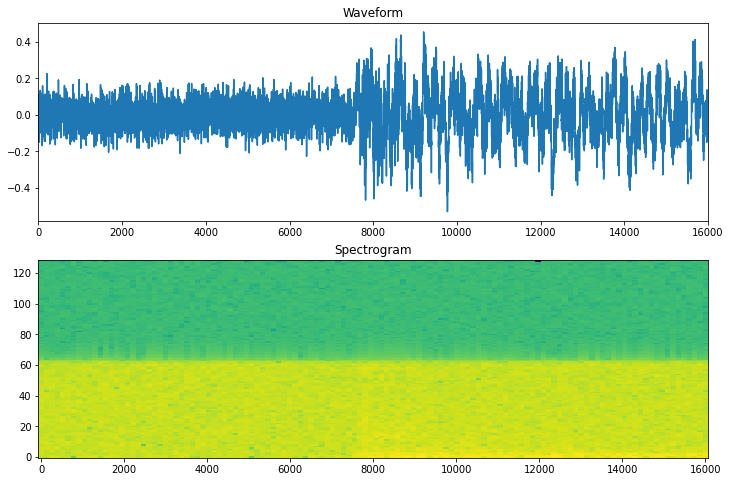

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [22]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == ['Crash','Horn'])
  return spectrogram, label_id

In [23]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

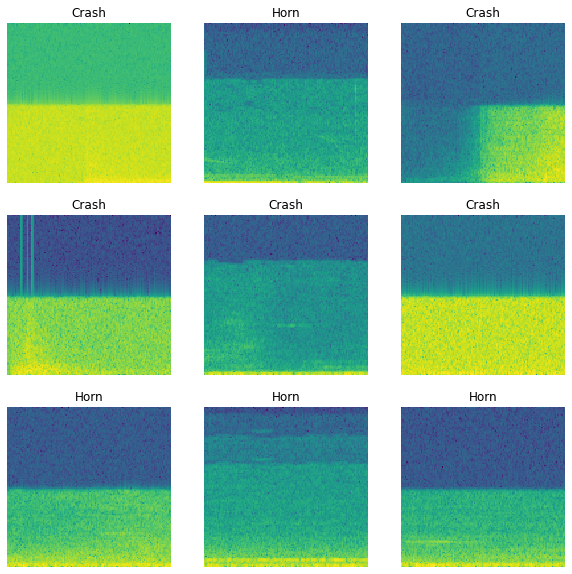

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
commands = ['Crash','Horn']
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build Model

In [25]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val)
test_ds = preprocess_dataset(test)

In [27]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
#hyperparameter
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_labels, activation = 'softmax')])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 129, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 65, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 31, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling 

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS,
)

Epoch 1/20
58/58 [==============================] - 43s 736ms/step - loss: 0.2133 - accuracy: 0.9051 - val_loss: 0.0871 - val_accuracy: 0.9784
Epoch 2/20
58/58 [==============================] - 47s 816ms/step - loss: 0.1098 - accuracy: 0.9666 - val_loss: 0.0421 - val_accuracy: 0.9871
Epoch 3/20
58/58 [==============================] - 34s 582ms/step - loss: 0.0790 - accuracy: 0.9741 - val_loss: 0.0446 - val_accuracy: 0.9871
Epoch 4/20
58/58 [==============================] - 51s 872ms/step - loss: 0.0645 - accuracy: 0.9795 - val_loss: 0.0201 - val_accuracy: 0.9957
Epoch 5/20
58/58 [==============================] - 43s 734ms/step - loss: 0.0526 - accuracy: 0.9854 - val_loss: 0.0230 - val_accuracy: 0.9957
Epoch 6/20
58/58 [==============================] - 42s 722ms/step - loss: 0.0734 - accuracy: 0.9746 - val_loss: 0.0236 - val_accuracy: 0.9957
Epoch 7/20
58/58 [==============================] - 44s 760ms/step - loss: 0.0530 - accuracy: 0.9817 - val_loss: 0.0240 - val_accuracy: 0.9914

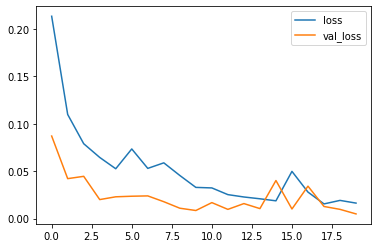

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [34]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 98%


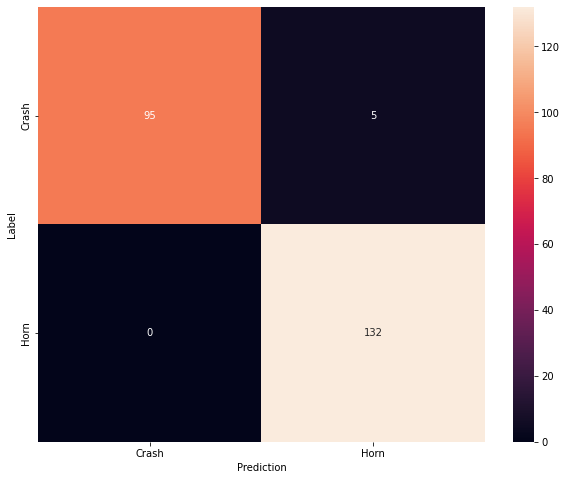

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Save Model

In [112]:
#savedir='ML Path/saved_model'
#model.save(savedir)

INFO:tensorflow:Assets written to: ML Path/DATASET FINAL/saved_model\assets


## Load Model

In [ ]:
#modeldir = '.h5
#new_model = tf.keras.models.load_model('my_model.h5')
#new_model.summary()

## Try with your audio !

In [95]:
def predictgraph(spec):
    prediction = model(spec)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{event[0]}"')
    plt.show()

In [100]:
event = ['Horn','Crash']
def predicting(path):
  waveform = decode_audio(path)
  spec = get_spectrogram(waveform) 
  spec = tf.reshape(spec, [1,124,129,1])
  print(f'Input Shape : {spec.shape}')
  predict = model.predict([spec])
  print(f'Predict Probability : {predict[0]}')
  floats = float(predict[0][0])
  prob = int(floats)
  predictresult = 0
  if floats != 0 or floats != 1 : #ini masih salah, pengennya bikin batasan buat unclassified -izul
      predictresult = "Unclassified"
  if floats > 0 and floats < 1:
    predictresult = event[prob]
  predictgraph(spec)
  display.display(display.Audio(waveform, rate=16000))
  return f"The audio {path} is {predictresult}"

Input Shape : (1, 124, 129, 1)
Predict Probability : [0.03171183 0.9682882 ]


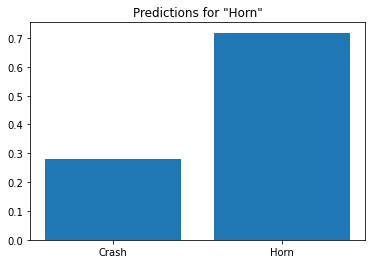

'The audio ML Path/DATASET FINAL/horn/horn_27_angin.wav is Horn'

In [104]:
predicting(data_dir+'/horn/horn_27_angin.wav')

### masih coba buat convert langsung masuk model

In [123]:
from pydub import AudioSegment

c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [137]:
def convert(file,output_dir):
    file = os.fsdecode(file)
    if file.endswith('.mp3') or file.endswith('.au') or file.endswith('.ogg'):
        sound = AudioSegment.from_mp3(file)
        soundwav = sound.export(output_dir+'/temp.wav', format="wav")
    if file.endswith('.wav'):
        pass
    else :
        raise TypeError("This function can only convert from these format: [.mp3, .au, .ogg]")
    return soundwav

In [138]:
testmp3 = 'ML Path/klakson (30).mp3'
output_dir = 'temp'
convert(testmp3,output_dir)

c:\Users\Ahmad Ulfi\AppData\Local\Programs\Python\Python39\lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] The system cannot find the file specified